In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import s2sphere as s2
import matplotlib.pyplot as plt
import haversine

In [2]:
def get_s2cell(lat, long, level):
    generator_obj = s2.CellId().from_lat_lng(s2.LatLng.from_degrees(lat, long)).parent(level)
    token = generator_obj.to_token()
    lat = generator_obj.to_lat_lng().lat().degrees
    lng = generator_obj.to_lat_lng().lng().degrees
    return (token, lat, lng)
get_s2cells = lambda df, level=14: pd.DataFrame(df.apply(lambda row: get_s2cell(row['lat_x'], row['lon_x'], level), axis=1).tolist(), columns=['token', 'slat', 'slng'])

norm = lambda df : la.norm(df.values, axis=1)



In [3]:
all_tweets = pd.read_pickle("../data/cleanmoji.pkl").drop_duplicates("id")#.head(10000)
all_tweets['created_at_date'] = pd.to_datetime(all_tweets['created_at'], infer_datetime_format=True)
all_tweets = all_tweets.merge(get_s2cells(all_tweets), left_index=True, right_index=True)
all_tweets.set_index('created_at_date', inplace=True)
plot = all_tweets.resample('1H').mean()[['slat', 'slng', 'Sent_1']]
track = pd.read_pickle("../data/track.pkl")
track['TIME_'] = track['TIME_'].dt.tz_localize("UTC")
track = track[['TIME_', 'LAT', 'LON', 'INTENSITY']]#.set_index("TIME_")
us_tweets = all_tweets[all_tweets['cc'] == "US"]
all_tweets['cc'].unique(), all_tweets.columns


(array(['US', 'BS', 'BR', 'DO', 'AR', 'AU', 'PR', 'NL', 'MX', 'GB', 'DE',
        'CL', 'TH', 'HT', 'VI', 'GH', 'KY', 'ES', 'GN', 'GR', 'JM', 'IN',
        'CA', 'FR', 'PH', 'SE', 'HN', 'PA', 'PE', 'CO', 'CR', 'ZA', 'IE',
        'ID', 'BD', 'JP', 'NG', 'MY', 'GP', 'CH', 'VE', 'SA', 'BE', 'PT',
        'CN', 'BB'], dtype=object),
 Index(['full_text', 'created_at', 'id', 'lon_x', 'lat_x', 'lat_y', 'lon_y',
        'name', 'admin1', 'admin2', 'cc', 'Text', 'Top5%', 'Emoji_1', 'Emoji_2',
        'Emoji_3', 'Emoji_4', 'Emoji_5', 'Pct_1', 'Pct_2', 'Pct_3', 'Pct_4',
        'Pct_5', 'Sent_1', 'Sent_2', 'Sent_3', 'Sent_4', 'Sent_5', 'token',
        'slat', 'slng'],
       dtype='object'))

In [4]:
# all_tweets.sort_values('created_at_date', inplace=True)
# track.sort_values('TIME_', inplace=True)
# mtrack = track.reindex(all_tweets.index, method='nearest').reset_index()
# sandy_tweets = pd.merge(all_tweets, mtrack, on='created_at_date', how='inner')
all_tweets.drop_duplicates('id').shape, all_tweets.shape


((67097, 31), (67097, 31))

In [5]:
sandy_tweets = pd.merge_asof(all_tweets.sort_index().reset_index(), track, left_on='created_at_date', right_on='TIME_', direction='nearest')
sandy_tweets.shape



(67097, 36)

In [19]:
train = sandy_tweets[['created_at_date', 'full_text', 'LAT', 'LON', 'lat_x', 'lon_x'] + [f'Sent_{i+1}' for i in range(5)]]
train['dist'] = haversine.haversine_vector(train[['lat_x', 'lon_x']].values, train[['LAT', 'LON']].values, unit='km')

<AxesSubplot:>

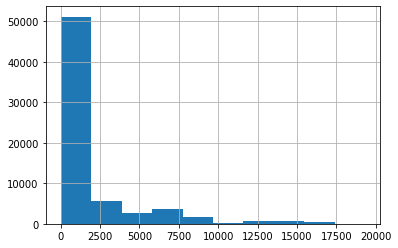

In [22]:
train['dist'].hist()

In [24]:
for i in range(5):
    print(train[f'Sent_{i+1}'].corr(train['dist']))



0.09247702230926066
0.09179882722371996
0.07808779185936454
0.06444760769551938
0.06124505325129686


In [32]:
n_bins = 4

train['label'], dists = pd.cut(train['dist'], bins=n_bins, labels=[i for i in range(n_bins)],retbins=True, precision=1)
dists

array([  -19.33943879,  4834.85969873,  9669.71939747, 14504.5790962 ,
       19339.43879494])

In [31]:
train.to_pickle("./../data/train.pkl", protocol=4)